In [1]:
import sys
sys.path.append('../')

import gpmp_scale.gp_utils as util

import gpmp_scale.svgp.SVGP as svgp
import gpmp_scale.gp_utils as util
import numpy as np
import pandas as pd
from gpmp_scale.gp_utils import load_climate_dataset, load_3d_road_dataset, load_bike_sharing_dataset, load_data
from gpmp_scale.gp_utils import normalize, plot_mean_variance

# 1. SVGP generate Dataset

In [12]:
train_x, train_y, test_x, test_y = load_data(N=20000, N_test=10000)

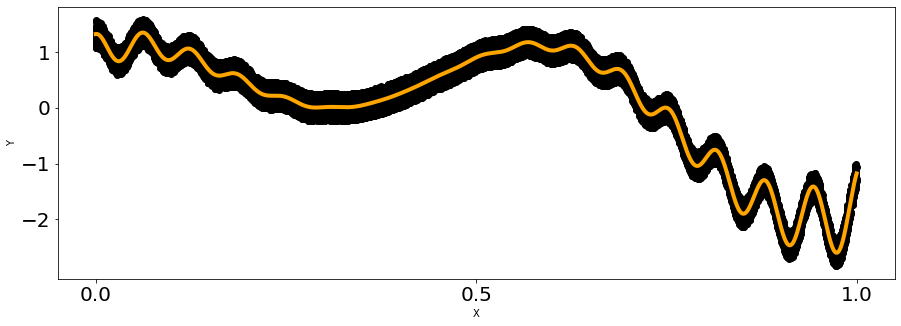

In [13]:
util.plot_data(train_x, train_y, test_x, test_y, file_name=f'SVGP_data.png')

root - INFO - Training SVGP


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.43439
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.25752
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0543
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(128, 1)",float64,[[0.06085...
SVGP.q_mu,Parameter,Identity,,True,"(128, 1)",float64,[[9.27310e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 128, 128)",float64,"[[[4.7200e-03, 0.0000e+00, 0.0000e+00..."


root - INFO - Time Process: 90.85920548439026
root - INFO - Test MAE: 0.11791947313280257
root - INFO - Test RMSE: 0.18394389136320372


(0.11791947313280257, 0.18394389136320372)

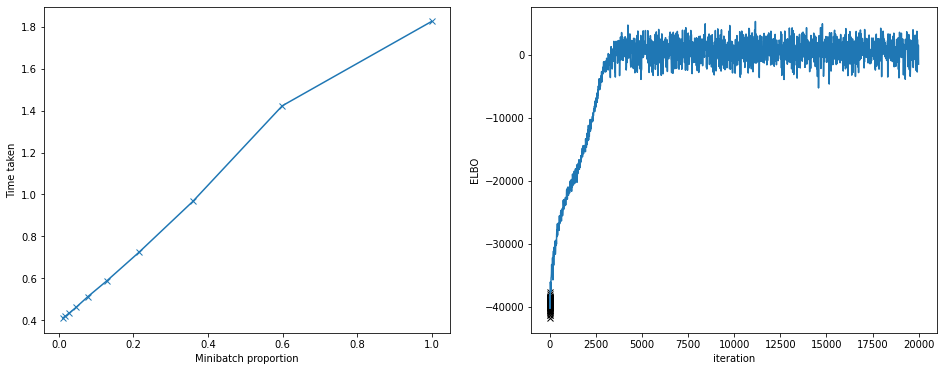

In [14]:
M = 128  # Number of inducing locations
model = svgp.train(train_x, train_y, minibatch_size=100, m_inducing=M)
y_mean, y_var = svgp.predict_y(model, test_x)
svgp.evaluate(test_y, y_mean)

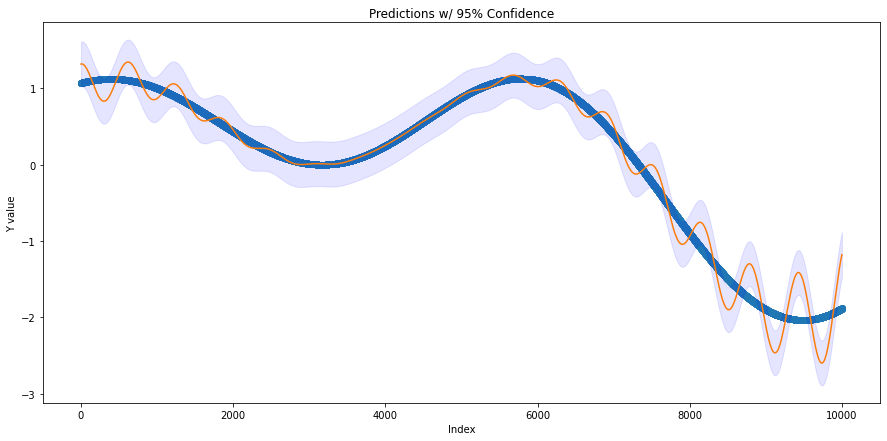

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
from sklearn import metrics

y_predict = y_mean.numpy()

residuals = sorted([x - y for x, y in zip(y_predict, test_y)])
valid = pd.DataFrame(test_y)
valid.columns = ['temp']

RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.6*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(valid.index, valid['temp'], color='#fc7d0b', label='Valid')
ax.scatter(valid.index, y_predict)
ax.fill_between(valid.index, (valid['temp']-band_size), (valid['temp']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Index')
ax.set_ylabel('Y value')
# ax.set_ylim(0,40)
plt.show()

# 2. SVGP Climate Dataset

In [3]:
def load_data():
    station_locations = np.load("climate/station_coord.npy")
    temperatures = np.load("climate/data.npy")
    N = len(station_locations) * len(temperatures)
    x_data = np.zeros((N, 3))
    y_data = np.zeros((N))
    count = 0
    for i in range(len(temperatures)):
        for j in range(len(temperatures[0])):
            x_data[count] = np.array([station_locations[j, 0], station_locations[j, 1], float(i)])
            y_data[count] = temperatures[i, j]
            count += 1

    non_nan_indices = np.where(y_data == y_data)  ###nans in data
    x_data = x_data[non_nan_indices]
    y_data = y_data[non_nan_indices]
    return x_data, y_data

In [4]:
%%time
x_data, y_data = load_climate_dataset()

CPU times: total: 1min 53s
Wall time: 1min 54s


In [5]:
x_data.shape

(51657174, 3)

In [6]:
x_data[:, 0] = normalize(x_data[:, 0])
x_data[:, 1] = normalize(x_data[:, 1])
x_data[:, 2] = normalize(x_data[:, 2])
y_data = normalize(y_data)

In [7]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, train_size=0.0004, test_size=0.0002,
                                                        random_state=42)


In [8]:
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

root - INFO - Training SVGP with minibatch_size: 100, m_inducing: 32, max_iter:20000
root - INFO - Training SVGP


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.68338
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.53391
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01433
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(32, 3)",float64,"[[0.43357, 0.57024, 0.18392..."
SVGP.q_mu,Parameter,Identity,,True,"(32, 1)",float64,[[0.71036...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 32, 32)",float64,"[[[0.00288, 0., 0...."


root - INFO - Time Process: 31.232566356658936
root - INFO - Test MAE: 0.09975890603697193
root - INFO - Test RMSE: 0.11943359540870152


CPU times: total: 58.8 s
Wall time: 31.4 s


(0.09975890603697193, 0.11943359540870152)

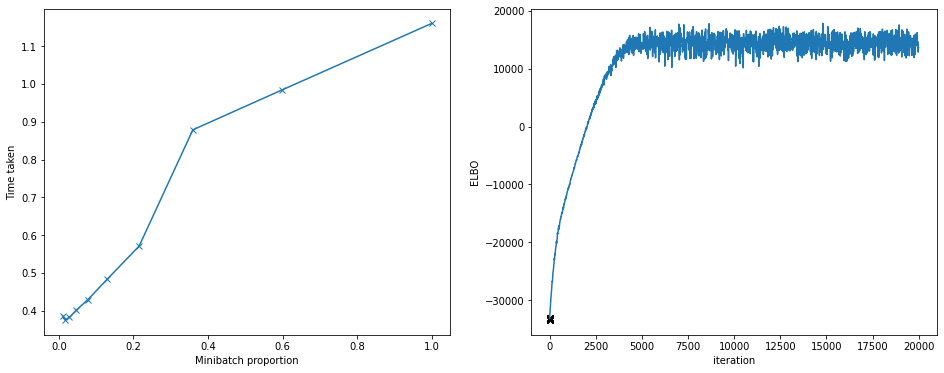

In [9]:
%%time
M = 32
model, _ = svgp.train(train_x, train_y, minibatch_size=100, m_inducing=M)
y_mean, y_var = svgp.predict_y(model, test_x)
svgp.evaluate(test_y, y_mean)

In [10]:
y_pred = y_mean.numpy()

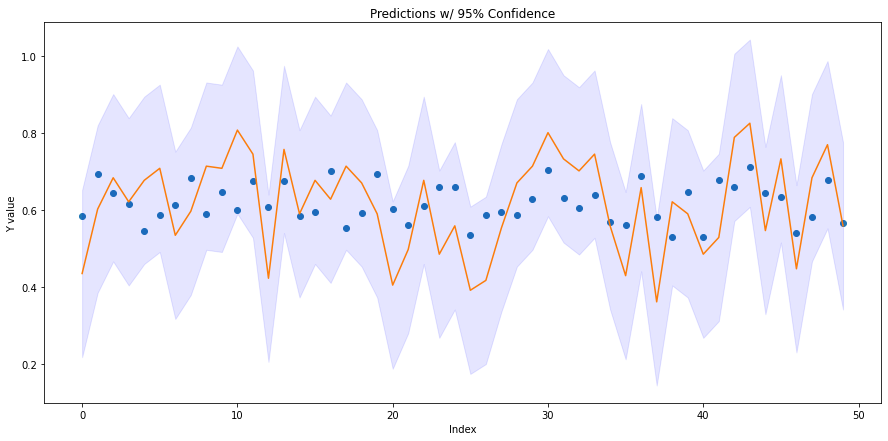

In [11]:
plot_mean_variance(test_y[:50], y_pred[:50])

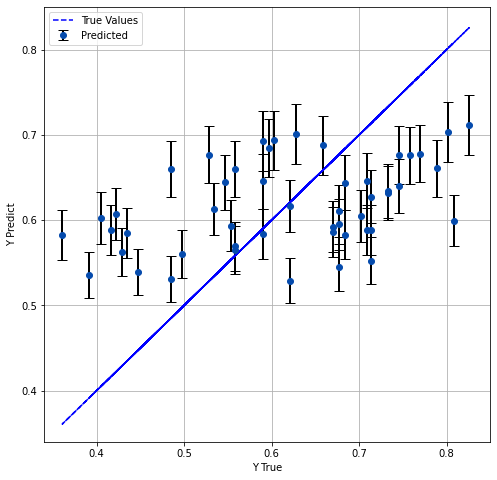

In [35]:
import matplotlib.pyplot as plt
def plot_95(test_y, y_pred):
    plt.figure(figsize=(8, 8))

    y_test = test_y[:50].reshape(-1)
    y_predict = y_pred[:50].reshape(-1)
    errors = y_predict * 0.05

    plt.errorbar(y_test, y_predict, yerr=errors, 
                 fmt='o', color='#054bad', ecolor='black', capsize=5, elinewidth=2, label='Predicted')

    plt.plot(y_test, y_test, 'b--', label='True Values')
    plt.ylim(0.34, 0.85)
    plt.xlim(0.34, 0.85)
    plt.xlabel('Y True')
    plt.ylabel('Y Predict')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_95(test_y, y_pred)

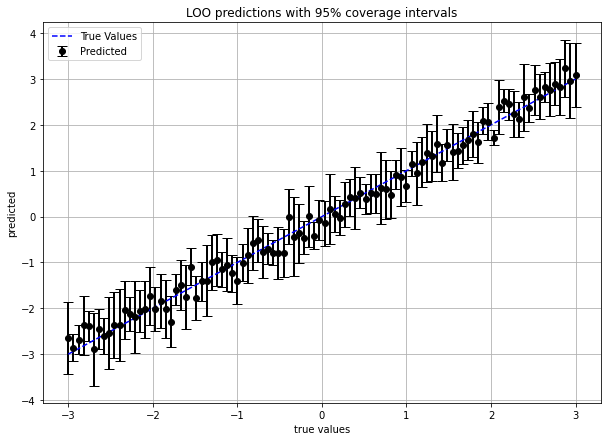

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'true_values' and 'predicted_means' are numpy arrays holding the true values and the predicted means, respectively.
# 'confidence_intervals' is a numpy array holding the upper and lower bounds of the 95% confidence intervals.

# For demonstration, let's create some dummy data that would represent a similar trend to what we see in the graph.
np.random.seed(0)  # For reproducibility
true_values = np.linspace(-3, 3, 100)
predicted_means = true_values + np.random.normal(0, 0.2, size=true_values.size)  # Add some noise
errors = np.random.normal(0.5, 0.15, size=true_values.size)  # Random errors for confidence intervals
lower_bounds = predicted_means - errors
upper_bounds = predicted_means + errors

# Now let's plot the LOO predictions with 95% coverage intervals
plt.figure(figsize=(10, 7))
plt.errorbar(true_values, predicted_means, yerr=[predicted_means - lower_bounds, upper_bounds - predicted_means], 
             fmt='o', color='black', ecolor='black', capsize=5, elinewidth=2, label='Predicted')
plt.plot(true_values, true_values, 'b--', label='True Values')  # Ideal 1:1 line

# Labeling the plot
plt.title('LOO predictions with 95% coverage intervals')
plt.xlabel('true values')
plt.ylabel('predicted')
plt.legend()
plt.grid(True)
plt.show()


root - INFO - Training SVGP with minibatch_size: 1000, m_inducing: 96, max_iter:20000
root - INFO - Training SVGP


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.67803
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.37004
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01424
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(96, 3)",float64,"[[0.43357, 0.57024, 0.18392..."
SVGP.q_mu,Parameter,Identity,,True,"(96, 1)",float64,[[7.1198e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 96, 96)",float64,"[[[0.00324, 0., 0...."


root - INFO - Time Process: 128.47029852867126
root - INFO - Test MAE: 0.09975310119974086
root - INFO - Test RMSE: 0.1194251677290766


CPU times: total: 7min 26s
Wall time: 2min 8s


(0.09975310119974086, 0.1194251677290766)

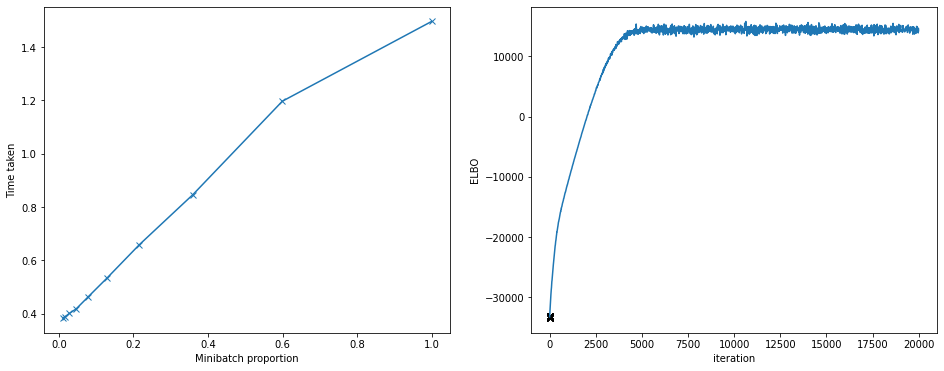

In [34]:
%%time
M = 96
model, _ = svgp.train(train_x, train_y, minibatch_size=1000, m_inducing=M)
y_mean, y_var = svgp.predict_y(model, test_x)
svgp.evaluate(test_y, y_mean)

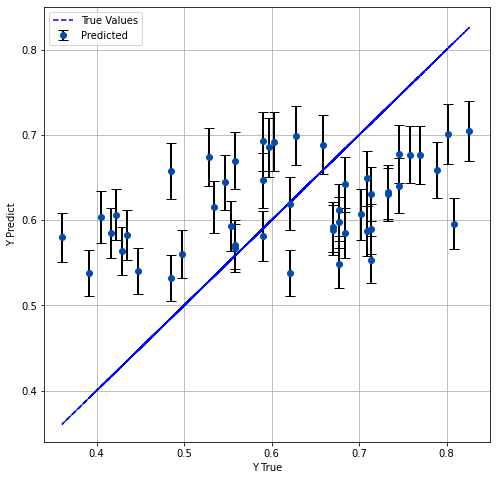

In [37]:
plot_95(test_y, y_mean.numpy())

root - INFO - Training SVGP with minibatch_size: 2000, m_inducing: 256, max_iter:20000
root - INFO - Training SVGP


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.67602
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.39034
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.01432
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(256, 3)",float64,"[[0.43357, 0.57024, 0.18392..."
SVGP.q_mu,Parameter,Identity,,True,"(256, 1)",float64,[[7.14600e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 256, 256)",float64,"[[[3.1900e-03, 0.0000e+00, 0.0000e+00..."


root - INFO - Time Process: 1358.941740989685
root - INFO - Test MAE: 0.09965722399906578
root - INFO - Test RMSE: 0.11937800071294645


(0.09965722399906578, 0.11937800071294645)

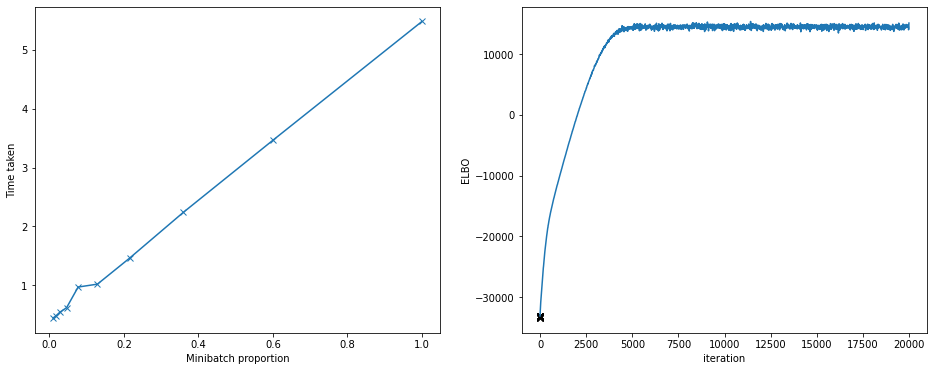

In [38]:
M = 256
model, _ = svgp.train(train_x, train_y, minibatch_size=2000, m_inducing=M)
y_mean, y_var = svgp.predict_y(model, test_x)
svgp.evaluate(test_y, y_mean)